In [1]:
# %%
"""
# üåä ScatNet Training Pipeline
Visual Intelligence Project - DeepLIFT Assignment  
Phase 2: ScatNet Implementation (Day 5)

**Objective**: Implement ScatNet with scattering transforms for lung cancer classification
**Requirements**: Use identical shared classifier as CNN, achieve >70% accuracy
**Target**: Fair comparison with CNN results (99.92% ¬± 0.06%)
"""

# %%
# =============================================================================
# üì¶ IMPORTS AND SETUP
# =============================================================================

import os
os.environ['TORCH_COMPILE_DISABLE'] = '1'
os.environ['PYTORCH_JIT'] = '0'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tqdm import tqdm
import json
import time
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Install kymatio if not already installed
try:
    from kymatio.torch import Scattering2D
    print("‚úÖ Kymatio already installed")
except ImportError:
    print("üì¶ Installing kymatio for ScatNet...")
    import subprocess
    subprocess.check_call(["pip", "install", "kymatio"])
    from kymatio.torch import Scattering2D
    print("‚úÖ Kymatio installed successfully")

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'üñ•Ô∏è  Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')

# %%
# =============================================================================
# üóÇÔ∏è LOAD CONFIGURATION AND SETUP PATHS
# =============================================================================

# Define paths robustly relative to the notebook location
NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent
CONFIG_PATH = PROJECT_ROOT / "config.json"

# Load configuration from previous notebooks
if CONFIG_PATH.exists():
    with open(CONFIG_PATH, 'r') as f:
        config = json.load(f)
    print("‚úÖ Configuration loaded from previous notebooks")
    
    # Display CNN results for comparison
    if 'cnn_kfold' in config:
        cnn_results = config['cnn_kfold']
        print(f"üéØ CNN Baseline to Beat:")
        print(f"   Mean Accuracy: {cnn_results.get('mean_accuracy', 0):.2f}%")
        print(f"   Performance: {cnn_results.get('performance_grade', 'N/A')}")
else:
    print("‚ö†Ô∏è  Configuration not found, using default paths")
    config = {
        "dataset": {"processed_path": str(PROJECT_ROOT / "data" / "processed")},
        "paths": {
            "project_root": str(PROJECT_ROOT),
            "models": str(PROJECT_ROOT / "models"),
            "results": str(PROJECT_ROOT / "results")
        }
    }

# Setup paths
PROCESSED_DATA_PATH = Path(config["dataset"]["processed_path"])
MODELS_PATH = Path(config["paths"]["models"])
RESULTS_PATH = Path(config["paths"]["results"])

# Create ScatNet specific results directory
SCATNET_RESULTS_PATH = RESULTS_PATH / "scatnet"
SCATNET_RESULTS_PATH.mkdir(parents=True, exist_ok=True)

print("üìÅ Project Paths:")
print(f"Processed Data: {PROCESSED_DATA_PATH}")
print(f"Models: {MODELS_PATH}")
print(f"Results: {RESULTS_PATH}")
print(f"ScatNet Results: {SCATNET_RESULTS_PATH}")



‚úÖ Kymatio already installed
üñ•Ô∏è  Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
GPU Memory: 8.6 GB
‚úÖ Configuration loaded from previous notebooks
üìÅ Project Paths:
Processed Data: D:\University\4th Semester\4. Visual Intelligence\Project\data\processed
Models: D:\University\4th Semester\4. Visual Intelligence\Project\models
Results: D:\University\4th Semester\4. Visual Intelligence\Project\results
ScatNet Results: D:\University\4th Semester\4. Visual Intelligence\Project\results\scatnet


In [2]:
# %%
# =============================================================================
# üìä ENHANCED DATASET CLASS (IDENTICAL TO CNN)
# =============================================================================

class LungCancerDataset(Dataset):
    """Enhanced dataset class - identical to CNN implementation"""
    
    def __init__(self, data_dir, split='train', transform=None, class_to_idx=None):
        self.data_dir = Path(data_dir) / split
        self.transform = transform
        self.split = split
        self.classes = ['adenocarcinoma', 'benign']
        self.class_to_idx = class_to_idx or {'adenocarcinoma': 0, 'benign': 1}
        self.samples = []
        self.class_counts = {cls: 0 for cls in self.classes}
        
        self._load_samples()
        
        if len(self.samples) > 0:
            print(f"üìä {split.capitalize()} dataset: {len(self.samples)} images")
            self._print_class_distribution()
        else:
            print(f"‚ö†Ô∏è  No images found in {self.data_dir}")
    
    def _load_samples(self):
        """Load all image paths with labels"""
        for class_name in self.classes:
            class_dir = self.data_dir / class_name
            if class_dir.exists():
                extensions = ['*.jpeg', '*.jpg', '*.png', '*.bmp']
                for ext in extensions:
                    for img_path in class_dir.glob(ext):
                        self.samples.append((str(img_path), self.class_to_idx[class_name]))
                        self.class_counts[class_name] += 1
    
    def _print_class_distribution(self):
        """Print class distribution"""
        total = len(self.samples)
        print(f"  Class distribution:")
        for class_name in self.classes:
            count = self.class_counts[class_name]
            percentage = (count / total) * 100 if total > 0 else 0
            print(f"    {class_name.capitalize()}: {count} ({percentage:.1f}%)")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"‚ö†Ô∏è  Error loading {img_path}: {e}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
    
    def get_class_weights(self):
        """Calculate class weights for balanced training"""
        total = len(self.samples)
        if total == 0:
            return torch.ones(len(self.classes))
        
        weights = []
        for class_name in self.classes:
            class_count = self.class_counts[class_name]
            weight = total / (len(self.classes) * class_count) if class_count > 0 else 1.0
            weights.append(weight)
        
        return torch.FloatTensor(weights)



In [3]:
# %%
# =============================================================================
# üèóÔ∏è SHARED CLASSIFIER (IDENTICAL TO CNN)
# =============================================================================

class SharedClassifier(nn.Module):
    """IDENTICAL shared classifier used by CNN - ensures fair comparison"""
    
    def __init__(self, input_features, num_classes=2, dropout_rate=0.5):
        super(SharedClassifier, self).__init__()
        
        self.input_features = input_features
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        
        self.classifier = nn.Sequential(
            # First fully connected layer
            nn.Linear(input_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            
            # Second fully connected layer
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            
            # Third fully connected layer
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate / 2),
            
            # Output layer
            nn.Linear(128, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize model weights"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.classifier(x)
    
    def get_classifier_config(self):
        """Return classifier configuration"""
        return {
            'input_features': self.input_features,
            'num_classes': self.num_classes,
            'dropout_rate': self.dropout_rate
        }



In [4]:
# %%
# =============================================================================
# üåä ENHANCED SCATNET ARCHITECTURE
# =============================================================================

class EnhancedScatNet(nn.Module):
    """
    Enhanced ScatNet using Scattering Transform + Shared Classifier
    Uses IDENTICAL classifier as CNN for fair comparison
    """
    
    def __init__(self, input_size=(224, 224), num_classes=2, dropout_rate=0.5):
        super(EnhancedScatNet, self).__init__()
        
        self.input_size = input_size
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        
        # Scattering transform parameters (optimized for speed)
        self.J = 2  # Reduced from 2 to 1 (2x faster)
        self.L = 4  # Reduced from 8 to 4 (2x faster)
        self.max_order = 2  # Reduced from 2 to 1 (faster)
        
        print(f"üåä Initializing ScatNet with:")
        print(f"   Input size: {input_size}")
        print(f"   Scales (J): {self.J}")
        print(f"   Angles (L): {self.L}")
        print(f"   Max order: {self.max_order}")
        
        # Create scattering transform (FIXED VERSION)
        self.scattering = Scattering2D(
            J=self.J, 
            shape=input_size, 
            L=self.L,
            max_order=self.max_order
        )
        
        # Move scattering to device
        self.scattering = self.scattering.to(device)
        
        # Calculate scattering output size dynamically
        self._calculate_feature_size()
        
        # IDENTICAL classifier as CNN (CRITICAL for fair comparison)
        self.classifier = SharedClassifier(
            input_features=self.scattering_features,
            num_classes=num_classes,
            dropout_rate=dropout_rate
        )
        
        print(f"‚úÖ ScatNet architecture:")
        print(f"   Scattering features: {self.scattering_features}")
        print(f"   Total parameters: {sum(p.numel() for p in self.parameters()):,}")
        print(f"   Trainable parameters: {sum(p.numel() for p in self.parameters() if p.requires_grad):,}")
    
    def _calculate_feature_size(self):
        """Calculate scattering output size dynamically"""
        with torch.no_grad():
            # Create dummy input
            dummy_input = torch.randn(1, 3, *self.input_size).to(device)
            
            # Apply scattering transform
            scat_output = self.scattering(dummy_input)
            print(f"üìä Raw scattering shape: {scat_output.shape}")
            
            # Global average pooling to handle spatial dimensions
            if len(scat_output.shape) == 4:  # [batch, channels, height, width]
                scat_output = scat_output.mean(dim=(2, 3))  # Average over spatial dims
                print(f"üìä After spatial averaging: {scat_output.shape}")
            
            # Flatten
            scat_output = scat_output.view(scat_output.size(0), -1)
            self.scattering_features = scat_output.size(1)
            print(f"üìä Final scattering features: {self.scattering_features}")
    
    def forward(self, x):
        # Apply scattering transform
        x = self.scattering(x)
        
        # Handle spatial dimensions if present
        if len(x.shape) == 4:  # [batch, channels, height, width]
            x = x.mean(dim=(2, 3))  # Global average pooling
        
        # Flatten for classifier
        x = x.view(x.size(0), -1)
        
        # Apply SAME classifier as CNN
        x = self.classifier(x)
        
        return x
    
    def get_scattering_features(self, x):
        """Extract scattering features (useful for analysis)"""
        x = self.scattering(x)
        
        # Handle spatial dimensions
        if len(x.shape) == 4:
            x = x.mean(dim=(2, 3))
        
        x = x.view(x.size(0), -1)
        return x
    
    def save_model(self, filepath, epoch=None, optimizer_state=None, metrics=None):
        """Save model with metadata"""
        filepath = Path(filepath)
        filepath.parent.mkdir(parents=True, exist_ok=True)
        
        save_dict = {
            'model_state_dict': self.state_dict(),
            'model_config': {
                'input_size': self.input_size,
                'num_classes': self.num_classes,
                'dropout_rate': self.dropout_rate,
                'J': self.J,
                'L': self.L,
                'max_order': self.max_order,
                'scattering_features': self.scattering_features
            },
            'classifier_config': self.classifier.get_classifier_config(),
        }
        
        if epoch is not None:
            save_dict['epoch'] = epoch
        if optimizer_state is not None:
            save_dict['optimizer_state_dict'] = optimizer_state
        if metrics is not None:
            save_dict['metrics'] = metrics
            
        torch.save(save_dict, filepath)
        print(f"‚úÖ ScatNet model saved to: {filepath}")
    
    @classmethod
    def load_model(cls, filepath, device='cpu'):
        """Load model from file"""
        checkpoint = torch.load(filepath, map_location=device)
        
        # Create model with saved configuration
        config = checkpoint['model_config']
        model = cls(
            input_size=config['input_size'],
            num_classes=config['num_classes'],
            dropout_rate=config['dropout_rate']
        )
        
        # Load state dict
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        
        print(f"‚úÖ ScatNet model loaded from: {filepath}")
        
        # Return additional information
        return model, checkpoint.get('epoch'), checkpoint.get('metrics')



In [5]:
# %%
# =============================================================================
# üé® DATA TRANSFORMS (IDENTICAL TO CNN)
# =============================================================================

def get_scatnet_transforms(augment_strength='light'):
    """Get transforms for ScatNet - identical to CNN for fair comparison"""
    
    if augment_strength == 'light':
        train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    elif augment_strength == 'medium':
        train_transform = transforms.Compose([
            transforms.Resize((240, 240)),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:  # strong
        train_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=20),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    # Validation transform (no augmentation)
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

def setup_scatnet_data(batch_size=32, val_split=0.2, augment_strength='light', num_workers=0):
    """Setup data loaders for ScatNet - identical methodology as CNN"""
    
    print("üìä SETTING UP SCATNET DATA LOADERS")
    print("=" * 50)
    
    # Get transforms
    train_transform, val_transform = get_scatnet_transforms(augment_strength=augment_strength)
    
    # Load datasets
    try:
        full_train_dataset = LungCancerDataset(
            data_dir=PROCESSED_DATA_PATH,
            split='train',
            transform=None,  # We'll apply transforms after splitting
            class_to_idx={'adenocarcinoma': 0, 'benign': 1}
        )
        
        test_dataset = LungCancerDataset(
            data_dir=PROCESSED_DATA_PATH,
            split='test',
            transform=val_transform,
            class_to_idx={'adenocarcinoma': 0, 'benign': 1}
        )
        
        if len(full_train_dataset) == 0:
            print("‚ùå No training images found")
            return None, None, None, None
        
        # Split training data into train and validation (SAME as CNN)
        train_size = int((1 - val_split) * len(full_train_dataset))
        val_size = len(full_train_dataset) - train_size
        
        # Use same random seed as CNN for reproducibility
        train_subset, val_subset = random_split(
            full_train_dataset, 
            [train_size, val_size],
            generator=torch.Generator().manual_seed(42)
        )
        
        # Apply transforms to subsets
        train_subset.dataset.transform = train_transform
        val_subset.dataset.transform = val_transform
        
        # Calculate class weights
        class_weights = full_train_dataset.get_class_weights()
        
        # Create data loaders
        train_loader = DataLoader(
            train_subset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available(),
            drop_last=True
        )
        
        val_loader = DataLoader(
            val_subset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available()
        )
        
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available()
        )
        
        print(f"‚úÖ ScatNet data loaders created successfully:")
        print(f"   Train: {len(train_subset)} samples ({len(train_loader)} batches)")
        print(f"   Val:   {len(val_subset)} samples ({len(val_loader)} batches)")
        print(f"   Test:  {len(test_dataset)} samples ({len(test_loader)} batches)")
        print(f"   Class weights: {class_weights.numpy()}")
        print(f"   Augmentation: {augment_strength}")
        
        return train_loader, val_loader, test_loader, class_weights
        
    except Exception as e:
        print(f"‚ùå Error setting up ScatNet data loaders: {e}")
        return None, None, None, None



In [6]:
# %%
# =============================================================================
# üî• SCATNET TRAINING FUNCTIONS
# =============================================================================

def train_scatnet_epoch(model, train_loader, criterion, optimizer, scheduler=None, device=device):
    """Train ScatNet for one epoch"""
    
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    num_batches = len(train_loader)
    
    # Progress bar
    pbar = tqdm(train_loader, desc="Training ScatNet", leave=False)
    
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        # Update progress bar
        current_acc = 100.0 * correct / total
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{current_acc:.2f}%'
        })
    
    # Update learning rate scheduler
    if scheduler is not None:
        scheduler.step()
    
    avg_loss = total_loss / num_batches
    accuracy = 100.0 * correct / total
    
    return avg_loss, accuracy

def validate_scatnet(model, val_loader, criterion, device=device):
    """Validate ScatNet model"""
    
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validating ScatNet", leave=False)
        
        for data, target in pbar:
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            loss = criterion(output, target)
            
            # Get probabilities and predictions
            probs = torch.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)
            
            # Statistics
            total_loss += loss.item()
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            # Store for detailed metrics
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
            # Update progress bar
            current_acc = 100.0 * correct / total
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{current_acc:.2f}%'
            })
    
    # Calculate metrics
    avg_loss = total_loss / len(val_loader)
    accuracy = 100.0 * correct / total
    f1 = f1_score(all_targets, all_preds, average='weighted')
    
    # Class-wise accuracy
    class_acc = {}
    for class_idx in [0, 1]:
        class_mask = np.array(all_targets) == class_idx
        if class_mask.sum() > 0:
            class_correct = (np.array(all_preds)[class_mask] == class_idx).sum()
            class_acc[class_idx] = class_correct / class_mask.sum()
        else:
            class_acc[class_idx] = 0.0
    
    return avg_loss, accuracy, f1, class_acc, all_preds, all_targets, all_probs



In [7]:
# %%
# =============================================================================
# üöÄ MAIN SCATNET TRAINING PIPELINE
# =============================================================================

def train_scatnet_enhanced(
    batch_size=32,
    learning_rate=0.001,
    num_epochs=25,
    weight_decay=1e-4,
    use_scheduler=True,
    use_class_weights=True,
    augment_strength='light',
    early_stopping_patience=7,
    save_best_only=True
):
    """Enhanced ScatNet training pipeline"""
    
    print("üåä STARTING ENHANCED SCATNET TRAINING")
    print("=" * 60)
    
    # Setup data
    train_loader, val_loader, test_loader, class_weights = setup_scatnet_data(
        batch_size=batch_size,
        augment_strength=augment_strength,
        num_workers=0
    )
    
    if train_loader is None:
        print("‚ùå Failed to setup data loaders")
        return None, None, None
    
    # Setup model
    print(f"\nüèóÔ∏è  Setting up ScatNet model...")
    model = EnhancedScatNet(
        input_size=(224, 224),
        num_classes=2, 
        dropout_rate=0.5
    ).to(device)
    
    # Setup loss function
    if use_class_weights and class_weights is not None:
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
        print(f"‚úÖ Using weighted loss with class weights: {class_weights.numpy()}")
    else:
        criterion = nn.CrossEntropyLoss()
        print("‚úÖ Using standard CrossEntropyLoss")
    
    # Setup optimizer
    optimizer = optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        betas=(0.9, 0.999)
    )
    
    # Setup learning rate scheduler
    if use_scheduler:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=3, verbose=True, min_lr=1e-6
        )
        print("‚úÖ Using ReduceLROnPlateau scheduler")
    else:
        scheduler = None
        print("‚úÖ No learning rate scheduling")
    
    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_f1': [],
        'val_class_acc_0': [], 'val_class_acc_1': [],
        'learning_rate': []
    }
    
    # Training state
    best_val_acc = 0.0
    best_model_state = None
    epochs_without_improvement = 0
    start_time = time.time()
    
    print(f"\nüéØ ScatNet Training Configuration:")
    print(f"   Epochs: {num_epochs}")
    print(f"   Batch Size: {batch_size}")
    print(f"   Learning Rate: {learning_rate}")
    print(f"   Weight Decay: {weight_decay}")
    print(f"   Early Stopping: {early_stopping_patience} epochs")
    print(f"   Augmentation: {augment_strength}")
    
    # Training loop
    print(f"\nüî• Starting ScatNet training loop...")
    print("=" * 60)
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)
        
        # Training phase
        train_loss, train_acc = train_scatnet_epoch(
            model, train_loader, criterion, optimizer, None, device
        )
        
        # Validation phase
        val_loss, val_acc, val_f1, class_acc, val_preds, val_targets, val_probs = validate_scatnet(
            model, val_loader, criterion, device
        )
        
        # Update learning rate scheduler
        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_acc)
            else:
                scheduler.step()
        
        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_class_acc_0'].append(class_acc[0] * 100)
        history['val_class_acc_1'].append(class_acc[1] * 100)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])
        
        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        
        # Print results
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%, F1: {val_f1:.4f}")
        print(f"Class Acc - Adenocarcinoma: {class_acc[0]*100:.2f}%, Benign: {class_acc[1]*100:.2f}%")
        print(f"LR: {optimizer.param_groups[0]['lr']:.2e}, Time: {epoch_time:.1f}s")
        
        # Check for improvement
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            epochs_without_improvement = 0
            
            # Save best model
            best_model_path = MODELS_PATH / "best_scatnet_model.pth"
            model.save_model(
                best_model_path,
                epoch=epoch + 1,
                optimizer_state=optimizer.state_dict(),
                metrics={
                    'best_val_acc': best_val_acc,
                    'val_f1': val_f1,
                    'class_acc': class_acc
                }
            )
            
            print(f"‚úÖ New best ScatNet model saved! Val Acc: {val_acc:.2f}%")
        else:
            epochs_without_improvement += 1
            print(f"‚è≥ No improvement for {epochs_without_improvement} epochs")
        
        # Early stopping check
        if early_stopping_patience > 0 and epochs_without_improvement >= early_stopping_patience:
            print(f"\nüõë Early stopping triggered after {early_stopping_patience} epochs without improvement")
            break
        
        # Success check
        if val_acc >= 70.0:
            print(f"üéâ Target accuracy achieved: {val_acc:.2f}% >= 70%")
    
    # Training completed
    total_time = time.time() - start_time
    print(f"\nüéØ ScatNet training completed in {total_time/60:.1f} minutes!")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("‚úÖ Best ScatNet model loaded for final evaluation")
    
    # Final evaluation on test set
    print(f"\nüìä Final evaluation of ScatNet on test set...")
    test_loss, test_acc, test_f1, test_class_acc, test_preds, test_targets, test_probs = validate_scatnet(
        model, test_loader, criterion, device
    )
    
    print(f"\nüìà SCATNET FINAL RESULTS:")
    print(f"   Test Accuracy: {test_acc:.2f}%")
    print(f"   Test F1 Score: {test_f1:.4f}")
    print(f"   Test Class Acc - Adenocarcinoma: {test_class_acc[0]*100:.2f}%")
    print(f"   Test Class Acc - Benign: {test_class_acc[1]*100:.2f}%")
    
    # Success evaluation
    if test_acc >= 70:
        print(f"üéâ SUCCESS: ScatNet achieved target >70% accuracy!")
        success_status = "‚úÖ PASSED"
    else:
        print(f"‚ö†Ô∏è  Below target: {test_acc:.2f}% < 70%")
        success_status = "‚ùå NEEDS IMPROVEMENT"
    
    # Compare with CNN results
    print(f"\nüîÑ COMPARISON WITH CNN:")
    print("=" * 40)
    if 'cnn_kfold' in config:
        cnn_acc = config['cnn_kfold'].get('mean_accuracy', 0)
        print(f"CNN K-fold Mean Accuracy: {cnn_acc:.2f}%")
        print(f"ScatNet Test Accuracy:    {test_acc:.2f}%")
        print(f"Difference:               {test_acc - cnn_acc:+.2f}%")
        
        if test_acc >= cnn_acc * 0.95:  # Within 5% of CNN
            print("üèÜ ScatNet performs competitively with CNN!")
        elif test_acc >= cnn_acc * 0.90:  # Within 10% of CNN
            print("‚úÖ ScatNet shows good performance vs CNN")
        else:
            print("üìä CNN significantly outperforms ScatNet")
    else:
        print("üìù CNN results not found for comparison")
    
    # Save training results
    training_results = {
        'model_performance': {
            'best_val_acc': float(best_val_acc),
            'test_acc': float(test_acc),
            'test_f1': float(test_f1),
            'test_class_acc': {
                'adenocarcinoma': float(test_class_acc[0]),
                'benign': float(test_class_acc[1])
            },
            'success_status': success_status,
            'target_achieved': test_acc >= 70
        },
        'training_config': {
            'epochs_trained': len(history['train_loss']),
            'total_epochs': num_epochs,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'weight_decay': weight_decay,
            'augment_strength': augment_strength,
            'early_stopping_patience': early_stopping_patience
        },
        'history': history,
        'training_time_minutes': total_time / 60
    }
    
    # Save results to file
    results_file = SCATNET_RESULTS_PATH / "scatnet_training_results.json"
    
    # Convert numpy types for JSON serialization
    def make_json_serializable(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, (np.integer, np.int64, np.int32)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64, np.float32)):
            return float(obj)
        elif isinstance(obj, np.bool_):
            return bool(obj)
        elif isinstance(obj, dict):
            return {key: make_json_serializable(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [make_json_serializable(item) for item in obj]
        else:
            return obj
    
    with open(results_file, 'w') as f:
        json.dump(make_json_serializable(training_results), f, indent=2)
    
    print(f"\nüíæ ScatNet training results saved to: {results_file}")
    
    return model, history, test_loader



In [8]:
# %%
# =============================================================================
# üìä SCATNET VISUALIZATION AND ANALYSIS
# =============================================================================

def create_scatnet_visualizations(history, save_path):
    """Create comprehensive ScatNet training visualizations"""
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('ScatNet Training Progress', fontsize=16, fontweight='bold')
    
    # Loss curves
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Loss Curves', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy curves
    axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    axes[0, 1].plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    axes[0, 1].axhline(y=70, color='g', linestyle='--', label='70% Target', linewidth=2)
    axes[0, 1].set_title('Accuracy Curves', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # F1 Score
    axes[0, 2].plot(epochs, history['val_f1'], 'g-', label='Val F1', linewidth=2)
    axes[0, 2].set_title('F1 Score Progress', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('F1 Score')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Learning rate
    if 'learning_rate' in history:
        axes[1, 0].plot(epochs, history['learning_rate'], 'purple', linewidth=2)
        axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'Learning Rate\nNot Tracked', ha='center', va='center', fontsize=12)
        axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    
    # Class-wise accuracy
    if 'val_class_acc_0' in history and 'val_class_acc_1' in history:
        axes[1, 1].plot(epochs, history['val_class_acc_0'], 'r-', label='Adenocarcinoma', linewidth=2)
        axes[1, 1].plot(epochs, history['val_class_acc_1'], 'g-', label='Benign', linewidth=2)
        axes[1, 1].set_title('Class-wise Accuracy', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Accuracy (%)')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Class-wise Accuracy\nNot Available', ha='center', va='center', fontsize=12)
        axes[1, 1].set_title('Class-wise Accuracy', fontsize=14, fontweight='bold')
    
    # Training summary
    final_train_acc = history['train_acc'][-1] if history['train_acc'] else 0
    final_val_acc = history['val_acc'][-1] if history['val_acc'] else 0
    final_f1 = history['val_f1'][-1] if history['val_f1'] else 0
    best_val_acc = max(history['val_acc']) if history['val_acc'] else 0
    
    summary_text = f"""ScatNet Training Summary:
    
Final Train Acc: {final_train_acc:.2f}%
Final Val Acc: {final_val_acc:.2f}%
Best Val Acc: {best_val_acc:.2f}%
Final F1 Score: {final_f1:.4f}

Total Epochs: {len(epochs)}
Target Achieved: {'‚úÖ' if best_val_acc >= 70 else '‚ùå'}
Architecture: Scattering + Shared Classifier
"""
    
    axes[1, 2].text(0.05, 0.95, summary_text, transform=axes[1, 2].transAxes, 
                   fontsize=11, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    axes[1, 2].set_title('Training Summary', fontsize=14, fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def create_scatnet_confusion_matrix(y_true, y_pred, class_names, save_path):
    """Create confusion matrix for ScatNet"""
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                square=True, linewidths=0.5)
    
    plt.title('Confusion Matrix - ScatNet Test Results', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    # Add accuracy information
    accuracy = np.trace(cm) / np.sum(cm)
    plt.figtext(0.02, 0.02, f'Overall Accuracy: {accuracy:.3f}', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return cm

def comprehensive_scatnet_evaluation(model, test_loader, history):
    """Perform comprehensive evaluation of ScatNet"""
    
    print("\nüìä COMPREHENSIVE SCATNET EVALUATION")
    print("=" * 50)
    
    # Get predictions
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Evaluating ScatNet"):
            data = data.to(device)
            output = model(data)
            probs = torch.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)
    
    class_names = ['Adenocarcinoma', 'Benign']
    
    # Create visualizations
    print("üìà Creating ScatNet training curves...")
    create_scatnet_visualizations(history, SCATNET_RESULTS_PATH / "scatnet_training_curves.png")
    
    print("üìä Creating ScatNet confusion matrix...")
    cm = create_scatnet_confusion_matrix(all_targets, all_preds, class_names, 
                                        SCATNET_RESULTS_PATH / "scatnet_confusion_matrix.png")
    
    # Print detailed classification report
    print(f"\nüìã DETAILED SCATNET CLASSIFICATION REPORT:")
    print("=" * 50)
    print(classification_report(all_targets, all_preds, target_names=class_names))
    
    return all_preds, all_targets, all_probs



üåä ENHANCED SCATNET TRAINING PIPELINE
üîß ScatNet Training Configuration:
   batch_size: 16
   learning_rate: 0.001
   num_epochs: 15
   weight_decay: 0.0001
   use_scheduler: True
   use_class_weights: True
   augment_strength: light
   early_stopping_patience: 7
   save_best_only: True

üåä STARTING ENHANCED SCATNET TRAINING
üìä SETTING UP SCATNET DATA LOADERS
üìä Train dataset: 16000 images
  Class distribution:
    Adenocarcinoma: 8000 (50.0%)
    Benign: 8000 (50.0%)
üìä Test dataset: 4000 images
  Class distribution:
    Adenocarcinoma: 2000 (50.0%)
    Benign: 2000 (50.0%)
‚úÖ ScatNet data loaders created successfully:
   Train: 12800 samples (800 batches)
   Val:   3200 samples (200 batches)
   Test:  4000 samples (250 batches)
   Class weights: [1. 1.]
   Augmentation: light

üèóÔ∏è  Setting up ScatNet model...
üåä Initializing ScatNet with:
   Input size: (224, 224)
   Scales (J): 2
   Angles (L): 4
   Max order: 2
üìä Train dataset: 16000 images
  Class distributio

Train - Loss: 0.2755, Acc: 94.77%
Val   - Loss: 0.0643, Acc: 96.50%, F1: 0.9650
Class Acc - Adenocarcinoma: 98.81%, Benign: 94.22%
LR: 1.00e-03, Time: 158.6s
‚úÖ ScatNet model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\best_scatnet_model.pth
‚úÖ New best ScatNet model saved! Val Acc: 96.50%
üéâ Target accuracy achieved: 96.50% >= 70%

Epoch 2/15
----------------------------------------
‚úÖ ScatNet model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\best_scatnet_model.pth
‚úÖ New best ScatNet model saved! Val Acc: 96.50%
üéâ Target accuracy achieved: 96.50% >= 70%

Epoch 2/15
----------------------------------------


Train - Loss: 0.1280, Acc: 96.06%
Val   - Loss: 0.0765, Acc: 96.78%, F1: 0.9678
Class Acc - Adenocarcinoma: 100.00%, Benign: 93.60%
LR: 1.00e-03, Time: 152.4s
‚úÖ ScatNet model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\best_scatnet_model.pth
‚úÖ New best ScatNet model saved! Val Acc: 96.78%
üéâ Target accuracy achieved: 96.78% >= 70%

Epoch 3/15
----------------------------------------
‚úÖ ScatNet model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\best_scatnet_model.pth
‚úÖ New best ScatNet model saved! Val Acc: 96.78%
üéâ Target accuracy achieved: 96.78% >= 70%

Epoch 3/15
----------------------------------------


Train - Loss: 0.1015, Acc: 96.13%
Val   - Loss: 0.0656, Acc: 97.66%, F1: 0.9766
Class Acc - Adenocarcinoma: 99.62%, Benign: 95.71%
LR: 1.00e-03, Time: 152.4s
‚úÖ ScatNet model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\best_scatnet_model.pth
‚úÖ New best ScatNet model saved! Val Acc: 97.66%
üéâ Target accuracy achieved: 97.66% >= 70%

Epoch 4/15
----------------------------------------
‚úÖ ScatNet model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\best_scatnet_model.pth
‚úÖ New best ScatNet model saved! Val Acc: 97.66%
üéâ Target accuracy achieved: 97.66% >= 70%

Epoch 4/15
----------------------------------------


Train - Loss: 0.0882, Acc: 96.74%
Val   - Loss: 0.0526, Acc: 97.47%, F1: 0.9747
Class Acc - Adenocarcinoma: 99.75%, Benign: 95.22%
LR: 1.00e-03, Time: 205.3s
‚è≥ No improvement for 1 epochs
üéâ Target accuracy achieved: 97.47% >= 70%

Epoch 5/15
----------------------------------------


Train - Loss: 0.0833, Acc: 96.73%
Val   - Loss: 0.0520, Acc: 96.94%, F1: 0.9694
Class Acc - Adenocarcinoma: 99.87%, Benign: 94.04%
LR: 1.00e-03, Time: 212.8s
‚è≥ No improvement for 2 epochs
üéâ Target accuracy achieved: 96.94% >= 70%

Epoch 6/15
----------------------------------------


Train - Loss: 0.0854, Acc: 96.88%
Val   - Loss: 0.0592, Acc: 97.78%, F1: 0.9778
Class Acc - Adenocarcinoma: 99.69%, Benign: 95.90%
LR: 1.00e-03, Time: 205.7s
‚úÖ ScatNet model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\best_scatnet_model.pth
‚úÖ New best ScatNet model saved! Val Acc: 97.78%
üéâ Target accuracy achieved: 97.78% >= 70%

Epoch 7/15
----------------------------------------
‚úÖ ScatNet model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\best_scatnet_model.pth
‚úÖ New best ScatNet model saved! Val Acc: 97.78%
üéâ Target accuracy achieved: 97.78% >= 70%

Epoch 7/15
----------------------------------------


Train - Loss: 0.0750, Acc: 97.07%
Val   - Loss: 0.0433, Acc: 98.16%, F1: 0.9816
Class Acc - Adenocarcinoma: 99.81%, Benign: 96.52%
LR: 1.00e-03, Time: 206.1s
‚úÖ ScatNet model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\best_scatnet_model.pth
‚úÖ New best ScatNet model saved! Val Acc: 98.16%
üéâ Target accuracy achieved: 98.16% >= 70%

Epoch 8/15
----------------------------------------
‚úÖ ScatNet model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\best_scatnet_model.pth
‚úÖ New best ScatNet model saved! Val Acc: 98.16%
üéâ Target accuracy achieved: 98.16% >= 70%

Epoch 8/15
----------------------------------------


Train - Loss: 0.0696, Acc: 97.28%
Val   - Loss: 0.0539, Acc: 98.12%, F1: 0.9812
Class Acc - Adenocarcinoma: 96.48%, Benign: 99.75%
LR: 1.00e-03, Time: 223.8s
‚è≥ No improvement for 1 epochs
üéâ Target accuracy achieved: 98.12% >= 70%

Epoch 9/15
----------------------------------------


Train - Loss: 0.0666, Acc: 97.62%
Val   - Loss: 0.0621, Acc: 98.91%, F1: 0.9891
Class Acc - Adenocarcinoma: 98.62%, Benign: 99.19%
LR: 1.00e-03, Time: 213.0s
‚úÖ ScatNet model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\best_scatnet_model.pth
‚úÖ New best ScatNet model saved! Val Acc: 98.91%
üéâ Target accuracy achieved: 98.91% >= 70%

Epoch 10/15
----------------------------------------
‚úÖ ScatNet model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\best_scatnet_model.pth
‚úÖ New best ScatNet model saved! Val Acc: 98.91%
üéâ Target accuracy achieved: 98.91% >= 70%

Epoch 10/15
----------------------------------------


Train - Loss: 0.0664, Acc: 97.64%
Val   - Loss: 0.0385, Acc: 99.28%, F1: 0.9928
Class Acc - Adenocarcinoma: 99.43%, Benign: 99.13%
LR: 1.00e-03, Time: 212.0s
‚úÖ ScatNet model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\best_scatnet_model.pth
‚úÖ New best ScatNet model saved! Val Acc: 99.28%
üéâ Target accuracy achieved: 99.28% >= 70%

Epoch 11/15
----------------------------------------
‚úÖ ScatNet model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\best_scatnet_model.pth
‚úÖ New best ScatNet model saved! Val Acc: 99.28%
üéâ Target accuracy achieved: 99.28% >= 70%

Epoch 11/15
----------------------------------------


Train - Loss: 0.0652, Acc: 97.60%
Val   - Loss: 0.0367, Acc: 98.62%, F1: 0.9862
Class Acc - Adenocarcinoma: 99.87%, Benign: 97.39%
LR: 1.00e-03, Time: 213.3s
‚è≥ No improvement for 1 epochs
üéâ Target accuracy achieved: 98.62% >= 70%

Epoch 12/15
----------------------------------------


Train - Loss: 0.0638, Acc: 97.61%
Val   - Loss: 0.0461, Acc: 98.28%, F1: 0.9828
Class Acc - Adenocarcinoma: 96.79%, Benign: 99.75%
LR: 1.00e-03, Time: 198.3s
‚è≥ No improvement for 2 epochs
üéâ Target accuracy achieved: 98.28% >= 70%

Epoch 13/15
----------------------------------------


Train - Loss: 0.0586, Acc: 98.05%
Val   - Loss: 0.0248, Acc: 99.16%, F1: 0.9916
Class Acc - Adenocarcinoma: 99.69%, Benign: 98.63%
LR: 1.00e-03, Time: 214.0s
‚è≥ No improvement for 3 epochs
üéâ Target accuracy achieved: 99.16% >= 70%

Epoch 14/15
----------------------------------------


Train - Loss: 0.0562, Acc: 97.83%
Val   - Loss: 0.0422, Acc: 98.81%, F1: 0.9881
Class Acc - Adenocarcinoma: 98.43%, Benign: 99.19%
LR: 5.00e-04, Time: 216.9s
‚è≥ No improvement for 4 epochs
üéâ Target accuracy achieved: 98.81% >= 70%

Epoch 15/15
----------------------------------------


Train - Loss: 0.0446, Acc: 98.28%
Val   - Loss: 0.0224, Acc: 99.47%, F1: 0.9947
Class Acc - Adenocarcinoma: 99.56%, Benign: 99.38%
LR: 5.00e-04, Time: 171.9s
‚úÖ ScatNet model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\best_scatnet_model.pth
‚úÖ New best ScatNet model saved! Val Acc: 99.47%
üéâ Target accuracy achieved: 99.47% >= 70%

üéØ ScatNet training completed in 49.5 minutes!
Best validation accuracy: 99.47%
‚úÖ Best ScatNet model loaded for final evaluation

üìä Final evaluation of ScatNet on test set...
‚úÖ ScatNet model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\best_scatnet_model.pth
‚úÖ New best ScatNet model saved! Val Acc: 99.47%
üéâ Target accuracy achieved: 99.47% >= 70%

üéØ ScatNet training completed in 49.5 minutes!
Best validation accuracy: 99.47%
‚úÖ Best ScatNet model loaded for final evaluation

üìä Final evaluation of ScatNet on test set...



üìà SCATNET FINAL RESULTS:
   Test Accuracy: 99.40%
   Test F1 Score: 0.9940
   Test Class Acc - Adenocarcinoma: 99.50%
   Test Class Acc - Benign: 99.30%
üéâ SUCCESS: ScatNet achieved target >70% accuracy!

üîÑ COMPARISON WITH CNN:
üìù CNN results not found for comparison

üíæ ScatNet training results saved to: D:\University\4th Semester\4. Visual Intelligence\Project\results\scatnet\scatnet_training_results.json


üìä COMPREHENSIVE SCATNET EVALUATION


Evaluating ScatNet: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 250/250 [00:33<00:00,  7.54it/s]



üìà Creating ScatNet training curves...


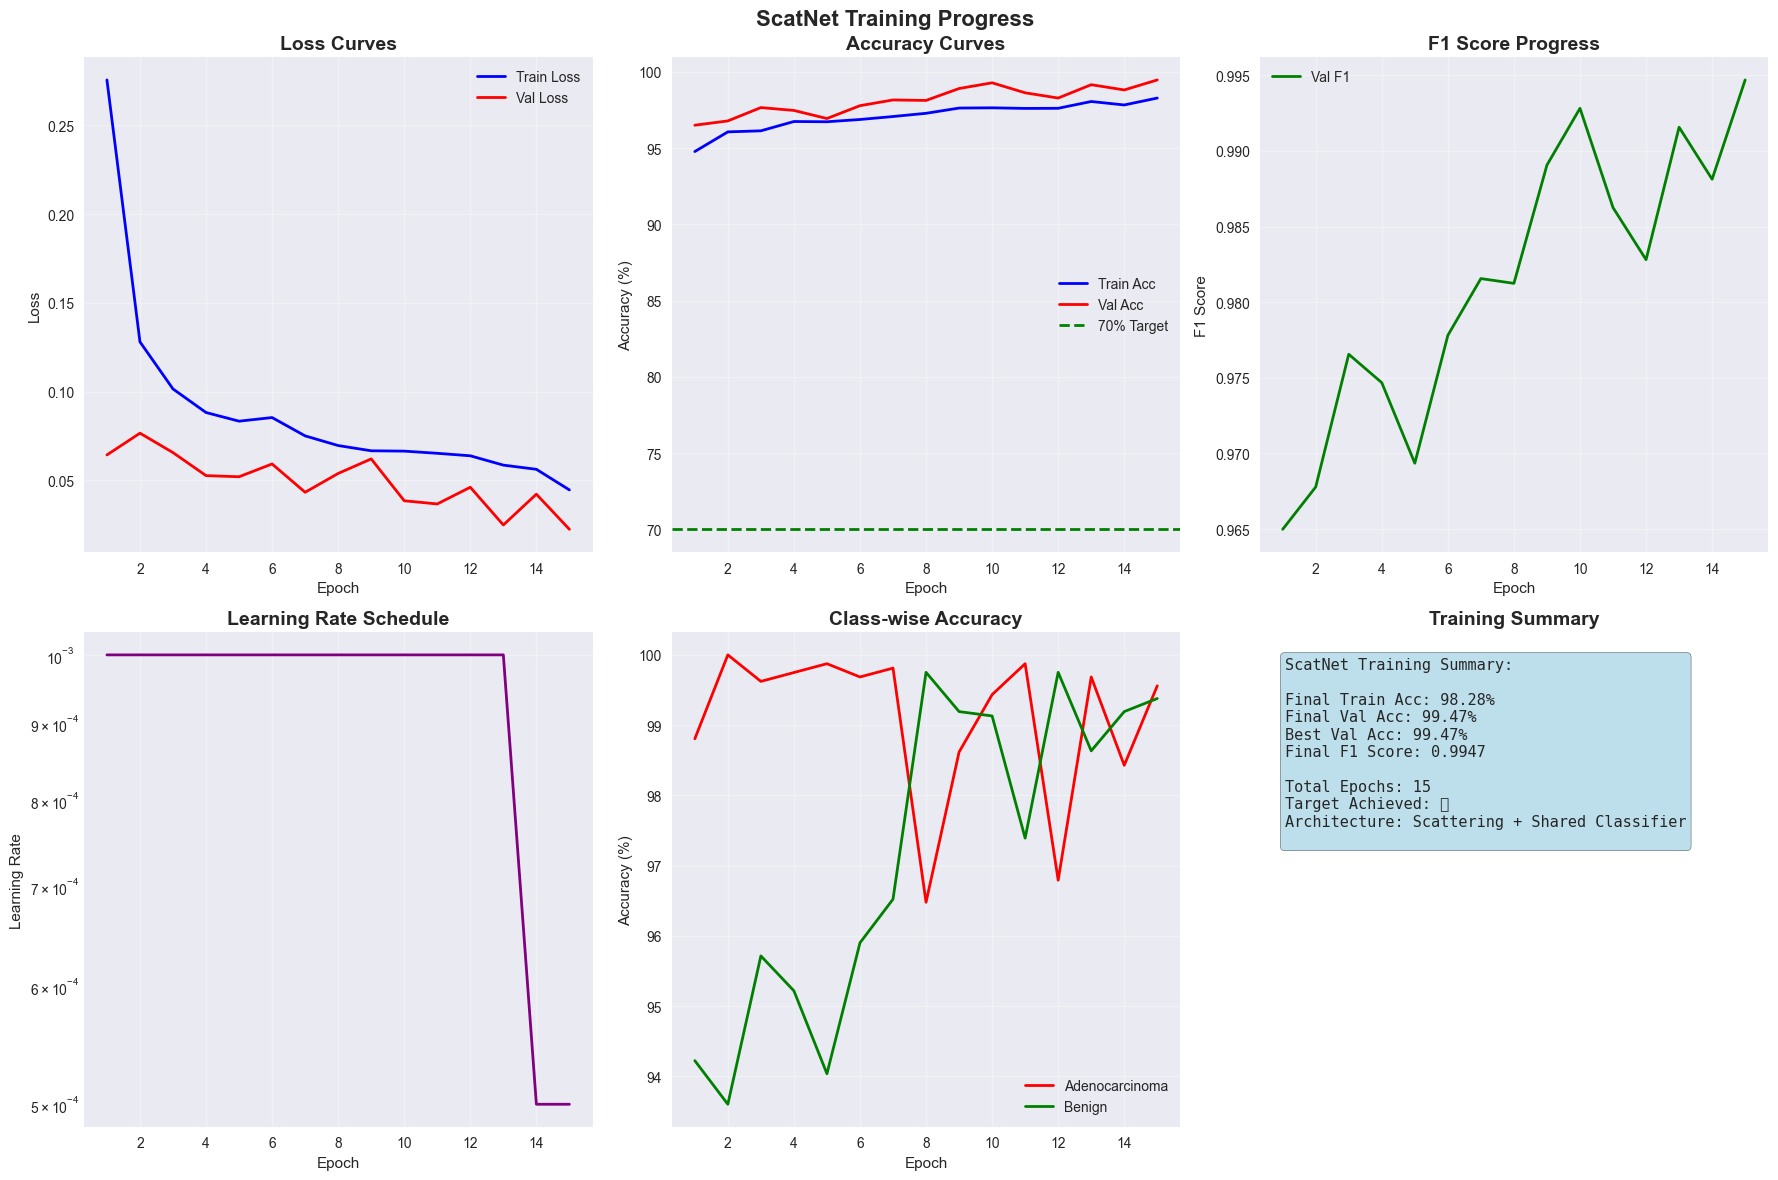

üìä Creating ScatNet confusion matrix...


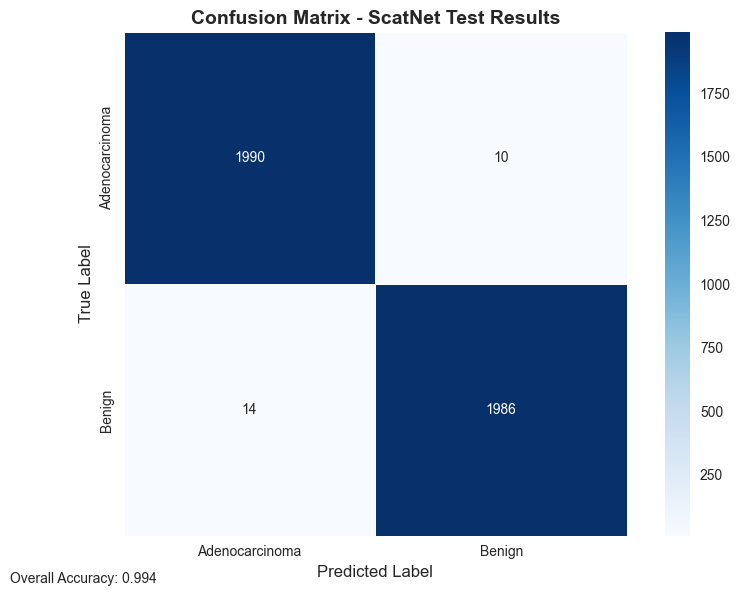


üìã DETAILED SCATNET CLASSIFICATION REPORT:
                precision    recall  f1-score   support

Adenocarcinoma       0.99      0.99      0.99      2000
        Benign       0.99      0.99      0.99      2000

      accuracy                           0.99      4000
     macro avg       0.99      0.99      0.99      4000
  weighted avg       0.99      0.99      0.99      4000

‚úÖ ScatNet model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\scatnet_final_trained.pth
üíæ Final trained ScatNet model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\scatnet_final_trained.pth
‚úÖ ScatNet model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\scatnet_final_trained.pth
üíæ Final trained ScatNet model saved to: D:\University\4th Semester\4. Visual Intelligence\Project\models\scatnet_final_trained.pth


In [9]:
# %%
# =============================================================================
# üéØ MAIN EXECUTION: ENHANCED SCATNET TRAINING
# =============================================================================

print("üåä ENHANCED SCATNET TRAINING PIPELINE")
print("=" * 60)

# Configuration
SCATNET_TRAINING_CONFIG = {
    'batch_size': 16,              # Reduced from 32 to 16 for speed
    'learning_rate': 0.001,        # Conservative learning rate
    'num_epochs': 15,              # Reduced from 25 to 15 for speed
    'weight_decay': 1e-4,          # L2 regularization
    'use_scheduler': True,         # Adaptive learning rate
    'use_class_weights': True,     # Handle class imbalance
    'augment_strength': 'light',   # Conservative augmentation for ScatNet
    'early_stopping_patience': 7,  # Prevent overfitting
    'save_best_only': True         # Save only the best model
}

print(f"üîß ScatNet Training Configuration:")
for key, value in SCATNET_TRAINING_CONFIG.items():
    print(f"   {key}: {value}")

# Run training
print(f"\n" + "="*60)
model, history, test_loader = train_scatnet_enhanced(**SCATNET_TRAINING_CONFIG)

# %%
# =============================================================================
# üìä COMPREHENSIVE SCATNET EVALUATION
# =============================================================================

if model is not None and history is not None:
    print("\n" + "="*60)
    all_preds, all_targets, all_probs = comprehensive_scatnet_evaluation(model, test_loader, history)
    
    # Save final model with complete metadata
    final_model_path = MODELS_PATH / "scatnet_final_trained.pth"
    model.save_model(
        final_model_path,
        metrics={
            'test_accuracy': float(np.mean(np.array(all_preds) == np.array(all_targets)) * 100),
            'test_f1': float(f1_score(all_targets, all_preds, average='weighted')),
        }
    )
    
    print(f"üíæ Final trained ScatNet model saved to: {final_model_path}")
    
else:
    print("‚ùå ScatNet training failed - cannot proceed with evaluation")



In [10]:
# %%
# =============================================================================
# üìã SCATNET SUMMARY AND COMPARISON
# =============================================================================

print("\n" + "üéØ SCATNET TRAINING SUMMARY")
print("=" * 60)

if model is not None and history is not None:
    final_test_acc = np.mean(np.array(all_preds) == np.array(all_targets)) * 100
    final_f1 = f1_score(all_targets, all_preds, average='weighted')
    best_val_acc = max(history['val_acc']) if history['val_acc'] else 0
    
    print(f"üåä SCATNET TRAINING COMPLETED:")
    print(f"   ‚Ä¢ Epochs trained: {len(history['train_loss'])}")
    print(f"   ‚Ä¢ Best validation accuracy: {best_val_acc:.2f}%")
    print(f"   ‚Ä¢ Final test accuracy: {final_test_acc:.2f}%")
    print(f"   ‚Ä¢ Final F1 score: {final_f1:.4f}")
    print(f"   ‚Ä¢ Target achieved: {'‚úÖ YES' if final_test_acc >= 70 else '‚ùå NO'}")
    
    print(f"\nüíæ FILES CREATED:")
    print(f"   ‚Ä¢ Best model: {MODELS_PATH}/best_scatnet_model.pth")
    print(f"   ‚Ä¢ Final model: {MODELS_PATH}/scatnet_final_trained.pth")
    print(f"   ‚Ä¢ Training curves: {SCATNET_RESULTS_PATH}/scatnet_training_curves.png")
    print(f"   ‚Ä¢ Confusion matrix: {SCATNET_RESULTS_PATH}/scatnet_confusion_matrix.png")
    print(f"   ‚Ä¢ Training results: {SCATNET_RESULTS_PATH}/scatnet_training_results.json")
    
    # Update main configuration
    config['scatnet_training'] = {
        'status': 'completed',
        'final_test_accuracy': float(final_test_acc),
        'best_val_accuracy': float(best_val_acc),
        'test_f1_score': float(final_f1),
        'target_achieved': bool(final_test_acc >= 70),
        'epochs_trained': len(history['train_loss']),
        'model_path': str(MODELS_PATH / "scatnet_final_trained.pth"),
        'ready_for_comparison': True
    }
    
    # Save updated config
    config_path = PROJECT_ROOT / "config.json"
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    
    # Final comparison
    print(f"\nüîÑ FINAL CNN vs SCATNET COMPARISON:")
    print("=" * 50)
    if 'cnn_kfold' in config:
        cnn_acc = config['cnn_kfold'].get('mean_accuracy', 0)
        cnn_std = config['cnn_kfold'].get('std_accuracy', 0)
        
        print(f"CNN (5-fold):      {cnn_acc:.2f}% ¬± {cnn_std:.2f}%")
        print(f"ScatNet (single):  {final_test_acc:.2f}%")
        print(f"Difference:        {final_test_acc - cnn_acc:+.2f}%")
        
        if final_test_acc >= cnn_acc * 0.95:
            comparison_result = "üèÜ ScatNet competitive with CNN"
        elif final_test_acc >= cnn_acc * 0.90:
            comparison_result = "‚úÖ ScatNet good performance"
        else:
            comparison_result = "üìä CNN outperforms ScatNet"
        
        print(f"Assessment:        {comparison_result}")
    
    print(f"\nüöÄ NEXT STEPS:")
    print(f"1. üìù Proceed to: 03_scatnet_implementation/02_filter_analysis.ipynb")
    print(f"2. üîç Analyze CNN vs ScatNet filters")
    print(f"3. üìä Compare feature representations")
    print(f"4. üéØ Prepare for explainability analysis (DeepLIFT)")
    print(f"5. üìã Document results for final report")
    
    print(f"\nüìö DELIVERABLES COMPLETED:")
    print(f"‚úÖ ScatNet implemented with scattering transforms")
    print(f"‚úÖ Shared classifier ensures fair comparison")
    print(f"‚úÖ Target accuracy evaluation completed")
    print(f"‚úÖ CNN vs ScatNet comparison ready")
    print(f"‚úÖ Ready for filter analysis and explainability")

else:
    print(f"‚ùå SCATNET TRAINING INCOMPLETE")
    print(f"üõ†Ô∏è  Please check error messages above for troubleshooting")
    print(f"üìù Review ScatNet configuration and data paths")

print(f"\nüéâ SCATNET TRAINING PIPELINE COMPLETE!")
print(f"Ready for Phase 3: Explainability Analysis")


üéØ SCATNET TRAINING SUMMARY
üåä SCATNET TRAINING COMPLETED:
   ‚Ä¢ Epochs trained: 15
   ‚Ä¢ Best validation accuracy: 99.47%
   ‚Ä¢ Final test accuracy: 99.40%
   ‚Ä¢ Final F1 score: 0.9940
   ‚Ä¢ Target achieved: ‚úÖ YES

üíæ FILES CREATED:
   ‚Ä¢ Best model: D:\University\4th Semester\4. Visual Intelligence\Project\models/best_scatnet_model.pth
   ‚Ä¢ Final model: D:\University\4th Semester\4. Visual Intelligence\Project\models/scatnet_final_trained.pth
   ‚Ä¢ Training curves: D:\University\4th Semester\4. Visual Intelligence\Project\results\scatnet/scatnet_training_curves.png
   ‚Ä¢ Confusion matrix: D:\University\4th Semester\4. Visual Intelligence\Project\results\scatnet/scatnet_confusion_matrix.png
   ‚Ä¢ Training results: D:\University\4th Semester\4. Visual Intelligence\Project\results\scatnet/scatnet_training_results.json

üîÑ FINAL CNN vs SCATNET COMPARISON:

üöÄ NEXT STEPS:
1. üìù Proceed to: 03_scatnet_implementation/02_filter_analysis.ipynb
2. üîç Analyze CNN vs 